In [1]:
import os, pandas as pd, numpy as np, json, matplotlib.pyplot as plt
from natsort import natsorted
from tqdm import tqdm 
os.chdir("./src/lib/hand_predictor")
from utils.hand.api import ffmpeg4format, mp_kpts_generator, mp_kpts_preprocessing, hand_pos_inference, model_pred_severity
from utils.hand.api import hand_rotation, hand_parameters
from utils.third_party.measurement import measurements
from utils.hand.keypoints import stft_plot, mergePlot_PeakInteRaw
import seaborn as sns

/home/yuy/miniconda3/envs/mediapipe/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing - workflow

## 1. Video -> MP4 

In [3]:
# input
root_path = '/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/righthand_videos'
# root_path = '/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/lefthand_videos'
filename_list = [ each for each in natsorted(os.listdir(root_path)) if '.avi' in each]

# output
temp_path = '/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/righthand_videos_mp4'
# temp_path = '/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/lefthand_videos_mp4'

for filename in tqdm(filename_list):
    filename_ = filename.split('.')[0]
    try:
        video_path = f'{root_path}/{filename}'
        output_path = f'{temp_path}/{filename_}.mp4'
        ffmpeg4format(video_path=video_path, output_path=output_path)
    except:
        print(filename)
#collect_hand_keypoints_pipe()

100%|██████████| 243/243 [02:40<00:00,  1.52it/s]


## 2. MP4 -> mediapipe kpts

In [4]:
pos_LR = 'Right'
# input
root_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{pos_LR.lower()}hand_videos_mp4'
filename_list = [ each for each in natsorted(os.listdir(root_path)) if '.mp4' in each]

# output
output_root_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{pos_LR.lower()}hand_mp_kpts'
os.makedirs(output_root_path, exist_ok=True)

for filename in tqdm(filename_list):
    video_path = f'{root_path}/{filename}'
    mp_kpts_generator(video_path=video_path, output_root_path=output_root_path, hand_query=pos_LR, logging=False)


100%|██████████| 243/243 [33:45<00:00,  8.34s/it]


## 3. Mediapipe kpts preprocessing (error frame ratio, supp with previous frame, normalize)

In [24]:
pos_LR = 'Right'

# input
root_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{pos_LR.lower()}hand_mp_kpts'
filename_list = [ each for each in natsorted(os.listdir(root_path)) if '.csv' in each ]

# output
output_root_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{pos_LR.lower()}hand_mp_kpts_preprocessed'
os.makedirs(output_root_path, exist_ok=True)

df_list = []
for filename in tqdm(filename_list):
    csv_input_path = f'{root_path}/{filename}'
    csv_output_path = f'{output_root_path}/{filename}'
    error_frame_ratio = mp_kpts_preprocessing(csv_input_path, csv_output_path, logging=False)
    
    df_list.append([filename, error_frame_ratio])

df = pd.DataFrame(df_list, columns=['filename', 'error_frame_ratio'])
df.to_csv(f"{output_root_path}/../{pos_LR.lower()}hand_filename_ErrorFrameRatio.csv", index=None)


100%|██████████| 243/243 [00:08<00:00, 29.12it/s]


## 4. Merge train-val dataset (label create)

In [22]:
hand_LR = 'right' # 'left', 'right'
datasets = ['train', 'val']

df_list = []
for dataset in datasets:
    read_txt = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{hand_LR}hand_{dataset}.txt'
    df = pd.read_table(read_txt, sep=' ', header=None, dtype=str)
    df.columns = ['filename', 'label']
    df_list.append(df)

df = pd.concat(df_list, axis=0)
df.reset_index(inplace=True, drop=True)
df.to_csv(f"/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{hand_LR}hand_merge.csv", index=None)

## 5. Merge csvname, labels, error frame ratio inforamtion

In [31]:
hand_LR = 'left' # 'left', 'right'
csv_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{hand_LR}hand_merge.csv'
csvEFR_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{hand_LR}hand_filename_ErrorFrameRatio.csv'

df_csv = pd.read_csv(csv_path)
df_csvEFR = pd.read_csv(csvEFR_path)

df = pd.concat([df_csvEFR, df_csv], axis=1)
df.columns = range(len(df.columns))
df = df[[0,3,1]]
df.columns = range(len(df.columns))
df.to_csv(f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{hand_LR}hand_clean.csv',header=None, index=None)

## 6. Relabel with dataset

In [6]:
hand_LR = 'left' # 'left', 'right'
severity_boundary = 5
csv_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{hand_LR}hand_clean.csv'
df = pd.read_csv(csv_path, header=None)
df[1] = [1 if each >= severity_boundary else 0 for each in df[1].values] ## modify here
df.to_csv(f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{hand_LR}hand_clean_{severity_boundary}.csv', index=None, header=None)

## 7. Rotation the hand (optional)

In [33]:
pos_LR = 'Right' # Right, Left

# input
root_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{pos_LR.lower()}hand_mp_kpts_preprocessed'
filename_list = [ each for each in natsorted(os.listdir(root_path)) if '.csv' in each ]

# output
output_root_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{pos_LR.lower()}hand_mp_kpts_preprocessed_rotat'
os.makedirs(output_root_path, exist_ok=True)

df_list = []
for filename in tqdm(filename_list):
    csv_input_path = f'{root_path}/{filename}'
    csv_output_path = f'{output_root_path}/{filename}'
    data_input = pd.read_csv(csv_input_path)
    data_output = hand_rotation(
        data_input, 
        'xyz',
        # [0, 90, 0], #left
        [0, -90, 0], #Right
        )
    data_output.to_csv(csv_output_path, index=None)


100%|██████████| 243/243 [00:03<00:00, 61.54it/s]


# Predict and Compare

## Hand position inference and compare to UPDRS 0/1 (normal/abnormal)

### Right hand

In [5]:
severity_boundary = 1
cfg_R, clean_results_R, clean_reuslts_woNA_R = hand_pos_inference(
    test_data_path="/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/righthand_mp_kpts_preprocessed",
    test_map_path=f"/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/righthand_clean_{severity_boundary}.csv",
    model_path=f"./utils/saved_models/DrGuo_3d_rotat_val_pick/Right_FG_{severity_boundary}/best.pth",
    args_path=f"./utils/saved_models/DrGuo_3d_rotat_val_pick/Right_FG_{severity_boundary}/args.txt",
    #output_folder="/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/righthand_clean_1_eval",
    seed=42,
    balance_dataset=True,
    multiple_sampling_num=5,
    random_rotat_3d=True,
    gau_samp=False,
    logging=True,
    device='cpu'
)


Checking the error frame ratio...
Files remains: 242/243 (0.996)
Raw test Acc 0.6459 F1 0.6459 Recall 0.6459


In [6]:
_ = measurements(
    clean_reuslts_woNA_R['label'].values,
    clean_reuslts_woNA_R['predict'].values,
    with_auc=False, printout=cfg_R['logging']
)

acc: 0.69
sensitivity: 0.68
TN: 24; FP: 9; FN: 66; TP: 143
specificity: 0.73
precision: 0.94
f1: 0.79
mcc: 0.29
npv: 0.27


### Left hand

In [7]:
severity_boundary = 1
cfg_L, clean_results_L, clean_reuslts_woNA_L = hand_pos_inference(
    test_data_path="/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/lefthand_mp_kpts_preprocessed",
    test_map_path="/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/lefthand_clean_1.csv",
    model_path=f"./utils/saved_models/DrGuo_3d_rotat_val_pick/Left_FG_{severity_boundary}/best.pth",
    args_path=f"./utils/saved_models/DrGuo_3d_rotat_val_pick/Left_FG_{severity_boundary}/args.txt",
    #output_folder="/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/lefthand_clean_1_eval",
    seed=42,
    balance_dataset=True,
    multiple_sampling_num=5,
    random_rotat_3d=True,
    gau_samp=False,
    logging=True,
    device='cpu'
)



Checking the error frame ratio...
Files remains: 360/368 (0.978)
Raw test Acc 0.6355 F1 0.6185 Recall 0.6355


In [8]:
_ = measurements(
    clean_reuslts_woNA_L['label'].values,
    clean_reuslts_woNA_L['predict'].values,
    with_auc=False, printout=cfg_L['logging']
)

acc: 0.50
sensitivity: 0.42
TN: 57; FP: 7; FN: 173; TP: 123
specificity: 0.89
precision: 0.95
f1: 0.58
mcc: 0.24
npv: 0.25


## Severity 

### Right

In [3]:
df_R = model_pred_severity(
    test_data_path="/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/righthand_mp_kpts_preprocessed",
    test_map_path="/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/righthand_clean.csv",
    hand="Right",
    random_rotat_3d=True,
    seed=42
)

In [4]:
df_R.head()

,csvname,label,error_frame_ratio,predict_Right_FG_1,predict_Right_FG_2,predict_Right_FG_3,predict_overall
0,00001_mp_hand_kpt.csv,1,0.000000,0.0,0.0,0.0,0.0
1,00002_mp_hand_kpt.csv,1,0.000000,0.0,0.0,0.0,0.0
2,00003_mp_hand_kpt.csv,1,0.086957,0.0,0.0,0.0,0.0
3,00004_mp_hand_kpt.csv,3,0.000000,1.0,1.0,1.0,3.0
4,00005_mp_hand_kpt.csv,1,0.000000,1.0,0.0,0.0,1.0


In [6]:
df_R.to_csv('/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/results_seed42/right_PDMotorDB_pred_3d_valpick_enhanced_feat.csv', index=None)

### Left 

In [7]:
df_L = model_pred_severity(
    test_data_path="/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/lefthand_mp_kpts_preprocessed",
    test_map_path="/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/lefthand_clean.csv",
    hand="Left",
    random_rotat_3d=True,
    seed=42
)

In [8]:
df_L.head()

,csvname,label,error_frame_ratio,predict_Left_FG_1,predict_Left_FG_2,predict_Left_FG_3,predict_overall
0,00001_mp_hand_kpt.csv,1,0.0,0.0,0.0,0.0,0.0
1,00002_mp_hand_kpt.csv,0,0.0,0.0,0.0,0.0,0.0
2,00003_mp_hand_kpt.csv,2,0.0,0.0,0.0,0.0,0.0
3,00004_mp_hand_kpt.csv,1,0.0,0.0,0.0,0.0,0.0
4,00005_mp_hand_kpt.csv,1,0.0,0.0,0.0,0.0,0.0


In [9]:
df_L.to_csv('/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/results_seed42/left_PDMotorDB_pred_3d_valpick_enhanced_feat.csv', index=None)

# Others: Traditional Hand keypoints (amplitude, frequency)

## Transform and Calculate

In [3]:
pos_LR = 'Right' # Right, Left

# input
root_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsonism/Data/PDMotorDB/{pos_LR.lower()}hand_mp_kpts_preprocessed'
filename_list = [ each for each in natsorted(os.listdir(root_path)) if '.csv' in each ]

# output
output_root_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsonism/Data/PDMotorDB/{pos_LR.lower()}hand_parameters_results'
os.makedirs(output_root_path, exist_ok=True)

for filename in tqdm(filename_list):
    results = {}
    csv_input_path = f'{root_path}/{filename}'
    json_output_path = f'{output_root_path}/{filename.replace(".csv", ".json")}'
    data_input = pd.read_csv(csv_input_path)
    results = hand_parameters(data_input=data_input)
    #print(json_output_path)
    with open(json_output_path, "w") as ff:
        json.dump(results, ff, indent=2)

100%|██████████| 243/243 [00:01<00:00, 190.80it/s]


In [13]:
pos_LR = 'Left' # Right, Left

# input
root_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{pos_LR.lower()}hand_parameters_results'
filename_list = [ each for each in natsorted(os.listdir(root_path)) if '.json' in each ]

# output
output_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{pos_LR.lower()}hand_parameters_results.csv'
df_list = []
for filename in tqdm(filename_list):
    json_input_path = f'{root_path}/{filename}'
    with open(json_input_path, "r") as ff:
        results = json.load(ff)
    df_list.append([
        filename, 
        results['freq-mean'], results['freq-std'], results['freq-median'], 
        results['intensity-mean'], results['intensity-std'], results['intensity-median'],
        results['peaks-mean'], results['peaks-std'], results['peaks-median'], 
        results['inte-freq-mean'], results['inte-freq-std'], results['inte-freq-median']])
df = pd.DataFrame(df_list, 
    columns=["filename", 
    "freq-mean", "freq-std", "freq-median", 
    "intensity-mean", "intensity-std", "intensity-median",
    "peaks-mean", "peaks-std", "peaks-median", 
    "inte-freq-mean", "inte-freq-std", "inte-freq-median"]
)
df.to_csv(output_path, index=None)


100%|██████████| 368/368 [00:00<00:00, 9669.20it/s]


## Read example

In [4]:
pos_LR = "Left"
# input
root_path = f'/home/yuy/Project/Gait_proj/fast_eval_Parkinsonism/Data/PDMotorDB/{pos_LR.lower()}hand_parameters_results'
filename_list = [ each for each in natsorted(os.listdir(root_path)) if '.json' in each ]

json_input_path = f"{root_path}/{filename_list[0]}"
with open(json_input_path, 'r') as ff:
    results = json.load(ff)

d, f = np.array(results["distance-thumb-ratio"]), np.array(results["frequency-interval"])
t, max_freq, max_intensity = np.array(results["stft"]["time"]), np.array(results["stft"]["freq"]), np.array(results["stft"]["intensity"])

## Plot

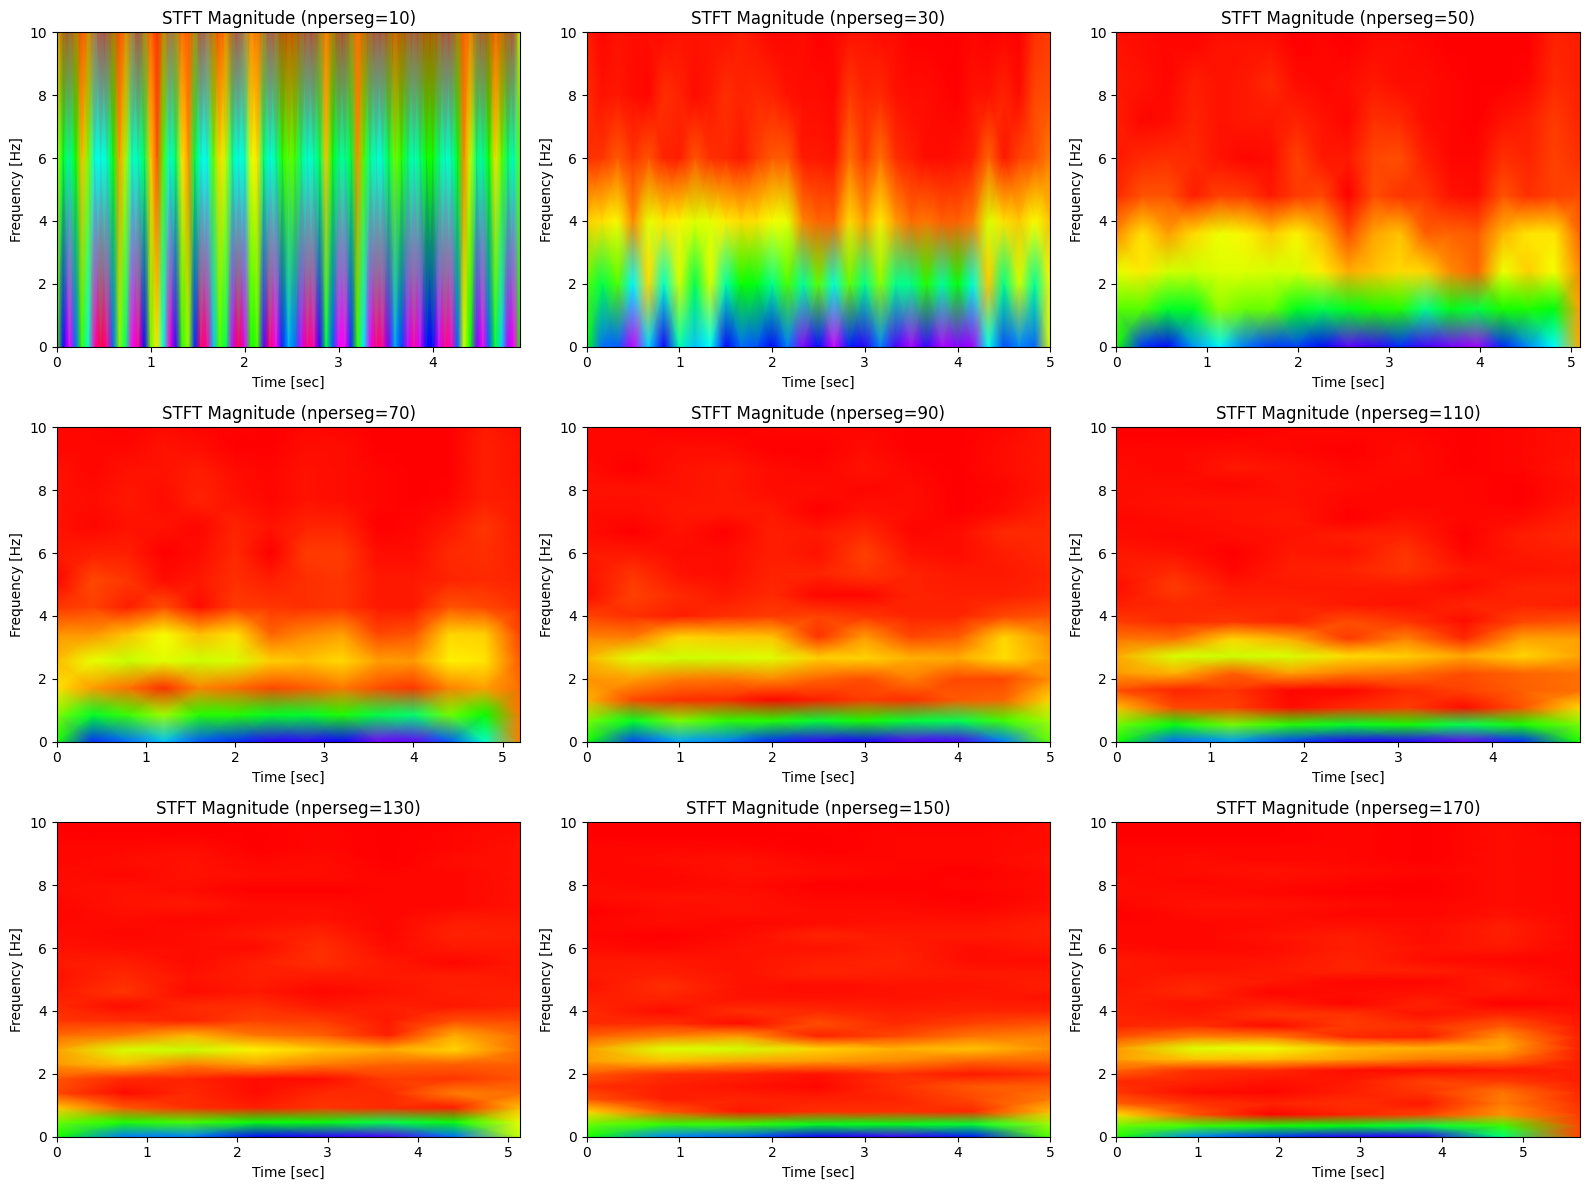

In [5]:
stft_plot(d)

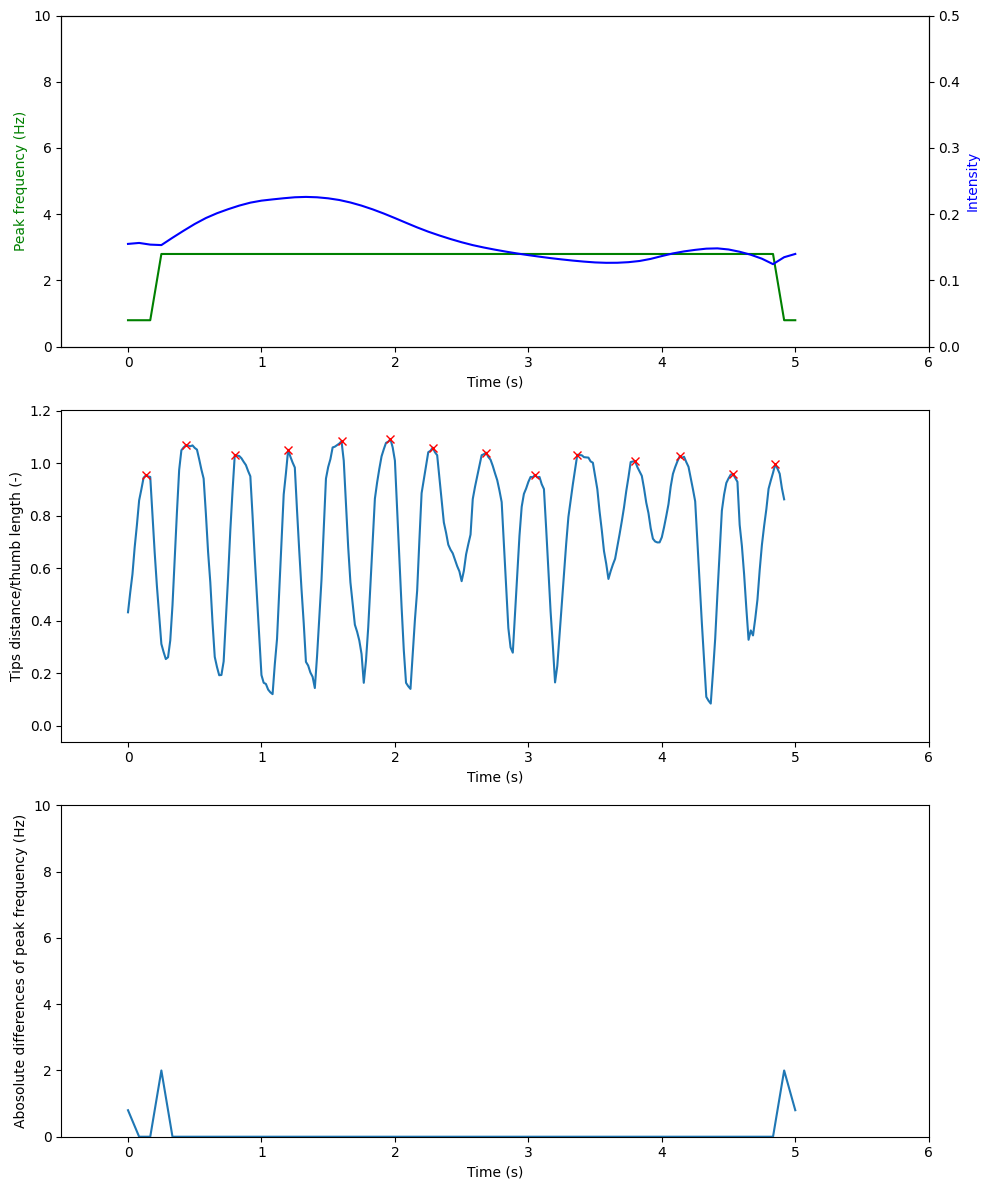

In [13]:
mergePlot_PeakInteRaw(
    t, d, max_freq=max_freq, max_intensity=max_intensity,
    inte_ylim_max=0.5
)

# Others: Plot the 3D keypoint from dataset

In [34]:
from utils.seed import set_seed
from utils.util import parse_args_keypoint
from utils.hand.dataset import PDHandData
import json, pandas as pd

###
severity_boundary=1
handness = 'right'
###

test_data_path=f"/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{handness}hand_mp_kpts_preprocessed"
test_map_path=f"/home/yuy/Project/Gait_proj/fast_eval_Parkinsons/Data/PDMotorDB/{handness}hand_clean_1.csv"
model_path=f"./utils/saved_models/DrGuo_3d_rotat_val_pick/{handness.capitalize()}_FG_{severity_boundary}/best.pth"
args_path=f"./utils/saved_models/DrGuo_3d_rotat_val_pick/{handness.capitalize()}_FG_{severity_boundary}/args.txt"
seed=42
balance_dataset=True
multiple_sampling_num=5
random_rotat_3d=True
gau_samp=False
logging=True
device='cpu'

set_seed(seed) # set seed

# load previous (training setting)
with open(args_path, 'r') as ff:
    cfg = json.load(ff)

# setting
cfg['test_data_path'] = test_data_path
cfg['test_map_path'] = test_map_path
cfg['model_path'] = model_path
cfg['args_path'] = args_path
cfg['output_folder'] = None
cfg['device'] = device
cfg['seed'] = seed
cfg['balance_dataset'] = balance_dataset
cfg['multiple_sampling_type'] = 'random-crop' # no other choice
cfg['multiple_sampling_num'] = multiple_sampling_num
cfg['random_rotat_3d'] = random_rotat_3d
cfg['gau_samp'] = gau_samp
cfg['logging'] = logging
## it is no need to balance dataset when prediction only
cfg['balance_dataset_method'] = 'None' if (cfg['balance_dataset'] == False) else 'random-crop'


# read and preprocessing data map
test_data_df_raw = pd.read_csv(test_map_path, header=None) # read
test_data_df = test_data_df_raw[~test_data_df_raw[0].str.contains("empty")] # filter out empty
if not cfg['low_confid_accept']: test_data_df = test_data_df[~test_data_df[0].str.contains("lowconfid")] # filter out low confidence data
test_data_df.reset_index(inplace=True, drop=True) # reset index


# enhanced features & keypoint selection
# (Priority: enhanced features > keypoint selection)
if cfg['enhanced_feat']:
    enhanced_type = cfg['category'].split("_")[-1]
    all_channels, channels_num = parse_args_keypoint(cfg['keypoint'])
    all_channels = all_channels + [f"enhanced_feat"]
    channels_num = len(all_channels)
else: 
    enhanced_type = 0
    all_channels, channels_num = parse_args_keypoint(cfg['keypoint'])

cfg['enhanced_type'] = enhanced_type
cfg['channels_num'] = channels_num

# classification class
class_map = {each_class: i for i, each_class in enumerate(sorted(test_data_df[1].unique()))}
class_num = len(class_map.keys())

# Check Acceptability domain: error_frame_ratio
if cfg['logging']: print("\nChecking the error frame ratio...")
origin_files_num = len(test_data_df)
test_data_mask = test_data_df[2]<=cfg['error_frame_thres'] # set: error frame ratio <= threshold
file_remained_ratio = sum(test_data_mask)/origin_files_num
test_data_df = test_data_df[test_data_mask] 
if cfg['logging']: print(f"Files remains: {len(test_data_df)}/{origin_files_num} ({file_remained_ratio:.3f})")

# dataset proccessing
test_dataset = PDHandData(filename_label_df=test_data_df,
                                input_channels=all_channels,
                                data_root=test_data_path,
                                seed=cfg['seed'],
                                mk_balanced_dataset=cfg['balance_dataset'],
                                mk_balanced_type=cfg['balance_dataset_method'],
                                multi_sample_type=cfg['multiple_sampling_type'],
                                multi_sample_num=cfg['multiple_sampling_num'],
                                enhanced_type=cfg['enhanced_type'],
                                random_rotat_3d=cfg['random_rotat_3d'],
                                group_map=class_map,
                                gaussian_sampling=cfg['gau_samp'],
                                crop_len=cfg['crop_len'],
                                return_name=True)


Checking the error frame ratio...
Files remains: 242/243 (0.996)


In [35]:
data_test = test_dataset.__getitem__(1)[0]
print(np.shape(data_test))
data_test = pd.DataFrame(data_test.T, columns=test_dataset.input_channels)

(64, 300)


In [38]:
new_data = hand_rotation(
    data_test, 
    rotat_axis='xyz', 
    rotat_angle=[0,90,0])

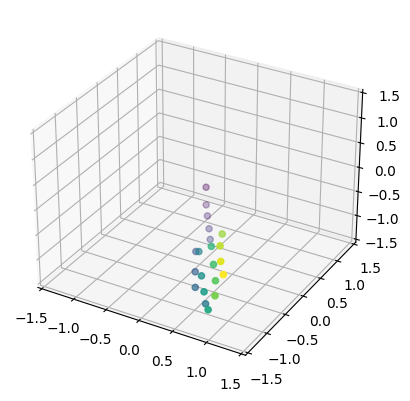

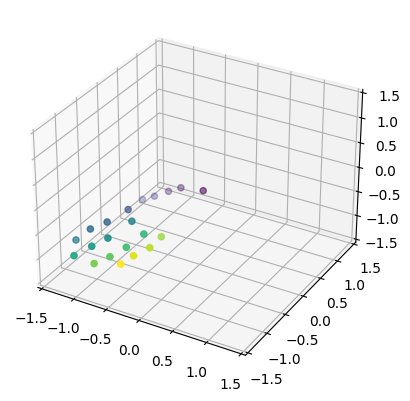

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def data_(new=False, time_frame=0):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(-1.5, 1.5)
    ax.set_ylim3d(-1.5, 1.5)
    ax.set_zlim3d(-1.5, 1.5)
    data = new_data.copy() if new else data_test.copy() 
    xdata = data.iloc[time_frame].filter(regex="x_").values
    ydata = data.iloc[time_frame].filter(regex="y_").values
    zdata = data.iloc[time_frame].filter(regex="z_").values
    ax.scatter3D(xdata, ydata, zdata,  c=range(len(xdata)))

data_(new=False, time_frame=200)
data_(new=True, time_frame=200)

# Comprehensive evaluation

In [3]:
hand_LR = "Right" # Left, Right
csv_path = f"/home/yuy/Project/Gait_proj/fast_eval_Parkinsonism/Data/PDMotorDB/Hand_PDMotorDB_pred_20221222_{hand_LR.lower()}.csv"
df = pd.read_csv(csv_path)
df.head()

,csvname,label,error_frame_ratio,YYY,DrGuo,predict_overall,predict_overall_3d_rotat,predict_overall_3d_rotat_infer_rotat,predict_overall_3d_rotat_val_pick,predict_overall_3d_rotat_val_pick_infer_3d_rotat,...,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82
0,00001_mp_hand_kpt.csv,1,0.000000,0.0,NaN,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00002_mp_hand_kpt.csv,1,0.000000,1.0,NaN,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00003_mp_hand_kpt.csv,1,0.086957,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00004_mp_hand_kpt.csv,3,0.000000,3.0,NaN,1.0,2.0,2.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00005_mp_hand_kpt.csv,1,0.000000,1.0,NaN,1.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


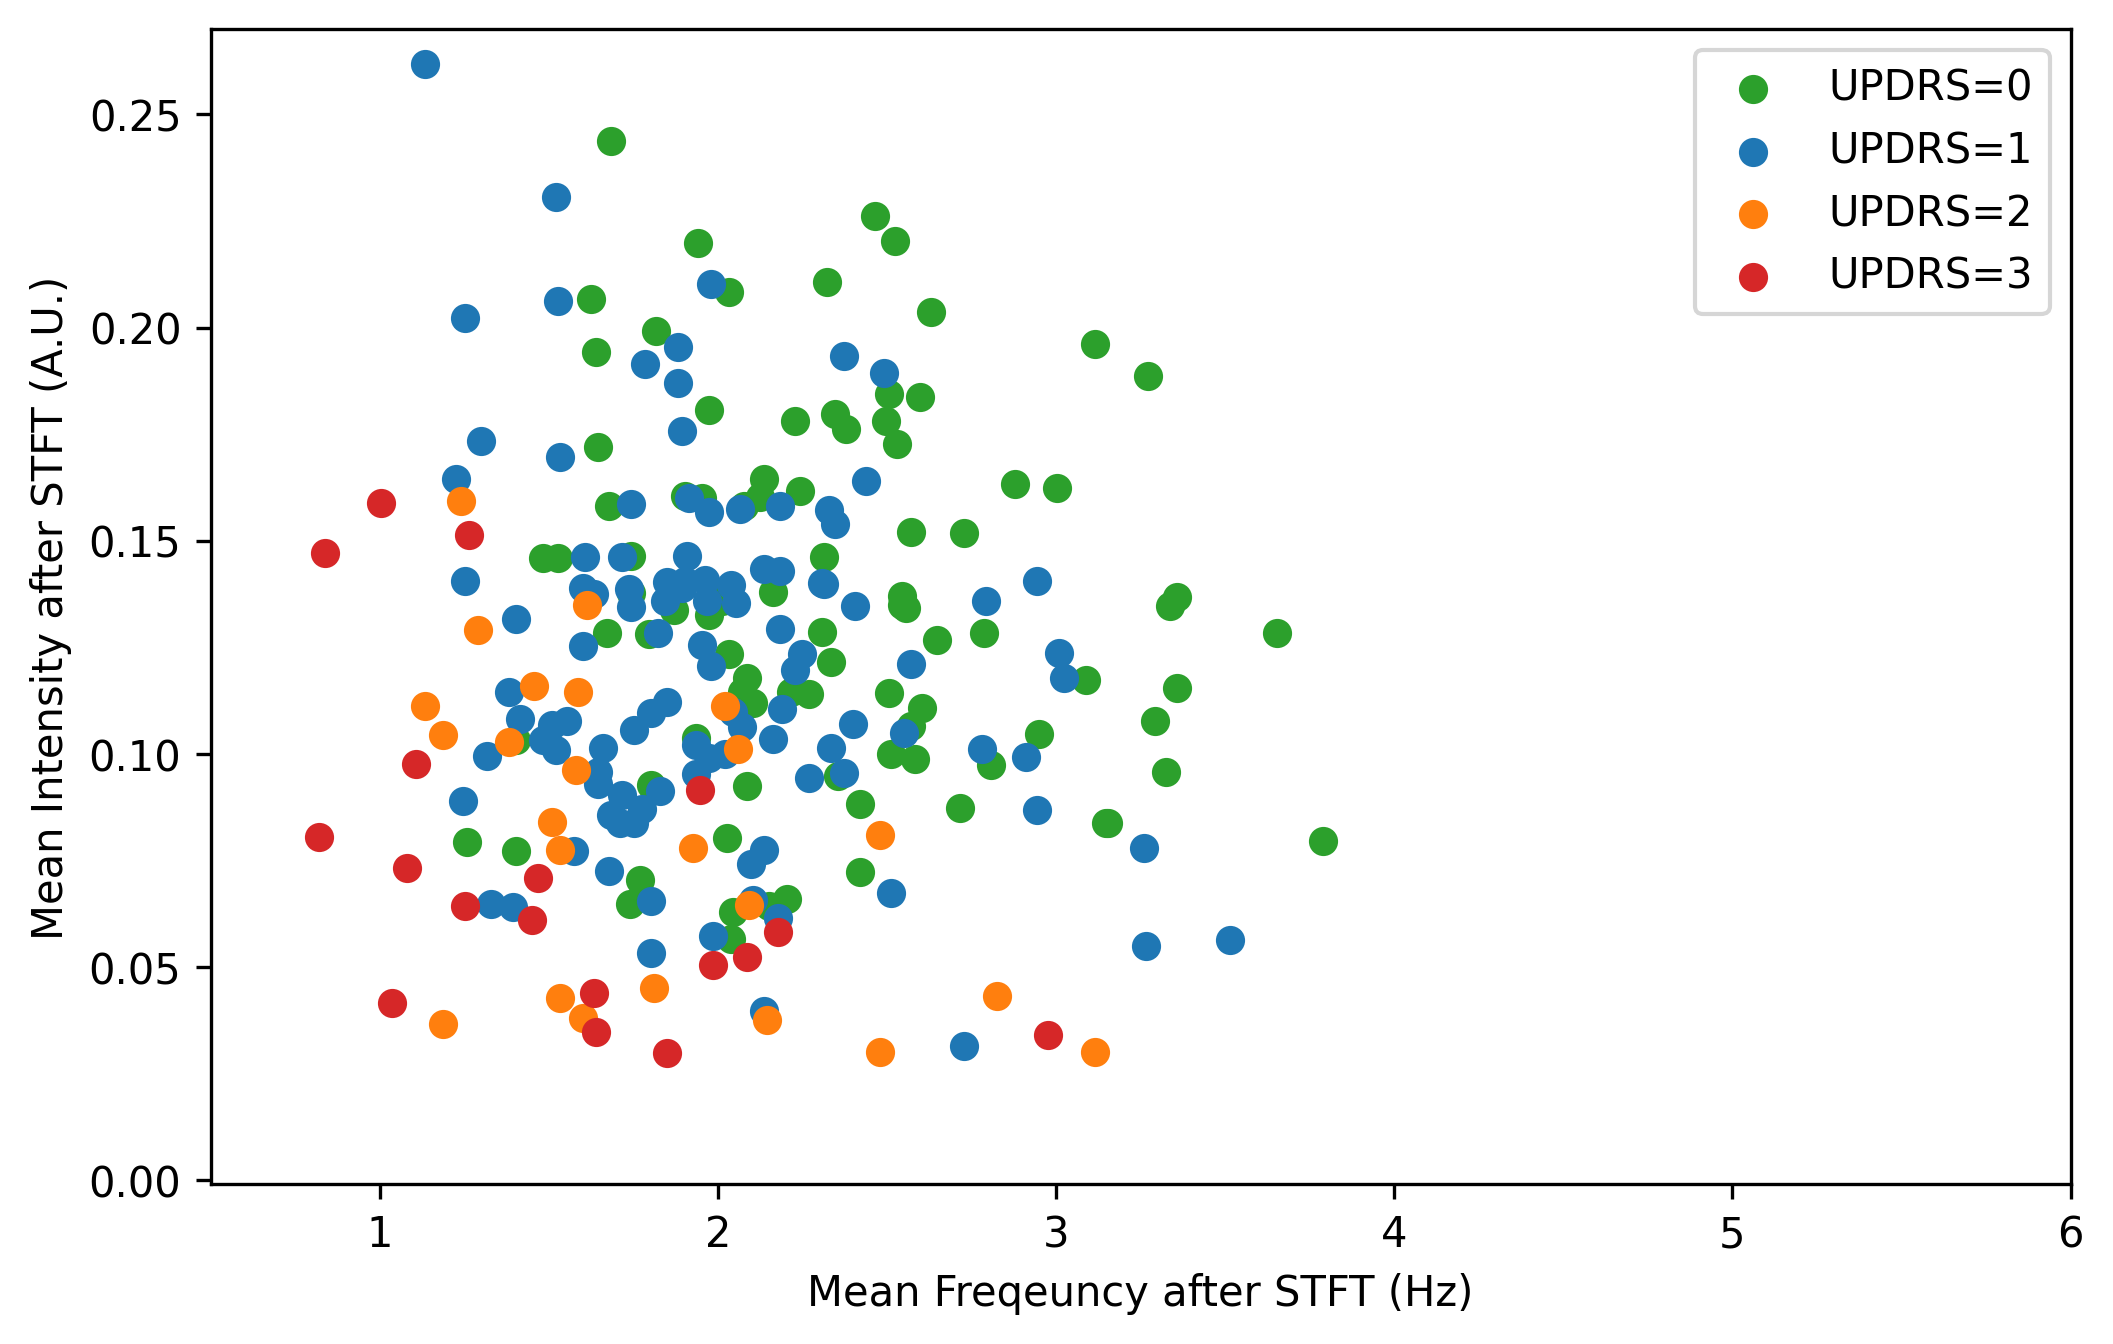

In [13]:
fig, ax = plt.subplots(1,1,figsize=[8,5],dpi=300)
colors = ["tab:green", "tab:blue", "tab:orange", "tab:red"]
for label, color_ in zip(range(4), colors):
    # df_plot = df[df['label']==label]
    df_plot = df[df['predict_overall_3d_rotat_val_pick_infer_3d_rotat']==label]
    # df_plot = df[df['YYY']==label]
    ax.scatter(df_plot['freq-mean'], df_plot['intensity-mean'], label=f"UPDRS={label}", color=color_)

ax.legend()
ax.set_ylabel("Mean Intensity after STFT (A.U.)")
ax.set_xlabel("Mean Freqeuncy after STFT (Hz)")
ax.set_xlim([0.5,6])
ax.set_ylim([-0.001,0.27])
#ax.set_ylim([-0.001,0.31])
fig.show()



In [7]:
df.columns

Index(['csvname', 'label', 'error_frame_ratio', 'YYY', 'DrGuo',
       'predict_overall', 'predict_overall_3d_rotat',
       'predict_overall_3d_rotat_infer_rotat',
       'predict_overall_3d_rotat_val_pick',
       'predict_overall_3d_rotat_val_pick_infer_3d_rotat',
       'predict_overall_3d_rotat_val_pick_infer_3d_rotat_seed43',
       'rotat_predict_overall_3d_rotat_val_pick_infer_3d_rotat_seed43',
       'predict_overall_3d_valpick_enhanced_feat', 'sticky', 'tremor',
       'hesitate/interrupt', 'slower and slower', 'smaller and smaller',
       'bradykenesia/slow (overall)', 'small (overall)', 'Symptom_num',
       'freq-mean', 'freq-std', 'freq-median', 'intensity-mean',
       'intensity-std', 'intensity-median', 'peaks-mean', 'peaks-std',
       'peaks-median', 'inte-freq-mean', 'inte-freq-std', 'inte-freq-median',
       'Excluded?', 'Note', 'Unnamed: 35', 'label/YYY', '0', '1', '2', '3',
       '4', 'Unnamed: 42', 'Unnamed: 43', 'label/YYY.1', '0.1', '1.1', '2.1',
       '3.

In [8]:
def quick_compare(xlabel="peaks-mean"):
    fig, axes = plt.subplots(2,2, figsize=[16,9], dpi=300)
    axes = axes.flatten()
    df_plot = df[(df['error_frame_ratio'] <= 0.5) & (df['label'] != 4)]

    sns.kdeplot(df_plot, x=xlabel, hue='label', fill=True, ax=axes[0], legend=False)
    axes[0].legend([f"UPDRS {3-i}" for i in range(4)])
    axes[0].set_title("Evaulated by orignial dataset")

    sns.ecdfplot(df_plot, x=xlabel, hue='label', ax=axes[1])
    axes[1].legend([f"UPDRS {3-i}" for i in range(4)])
    axes[1].set_title("Evaulated by orignial dataset")

    sns.kdeplot(df_plot, x=xlabel, hue='predict_overall_3d_rotat_val_pick_infer_3d_rotat', fill=True, ax=axes[2])
    axes[2].legend([f"UPDRS {3-i}" for i in range(4)])
    axes[2].set_title("Evaulated by DL model")

    sns.ecdfplot(df_plot, x=xlabel, hue='predict_overall_3d_rotat_val_pick_infer_3d_rotat', ax=axes[3])
    axes[3].legend([f"UPDRS {3-i}" for i in range(4)])
    axes[3].set_title("Evaulated by DL model")

    fig.tight_layout()
    fig.show()
    return None

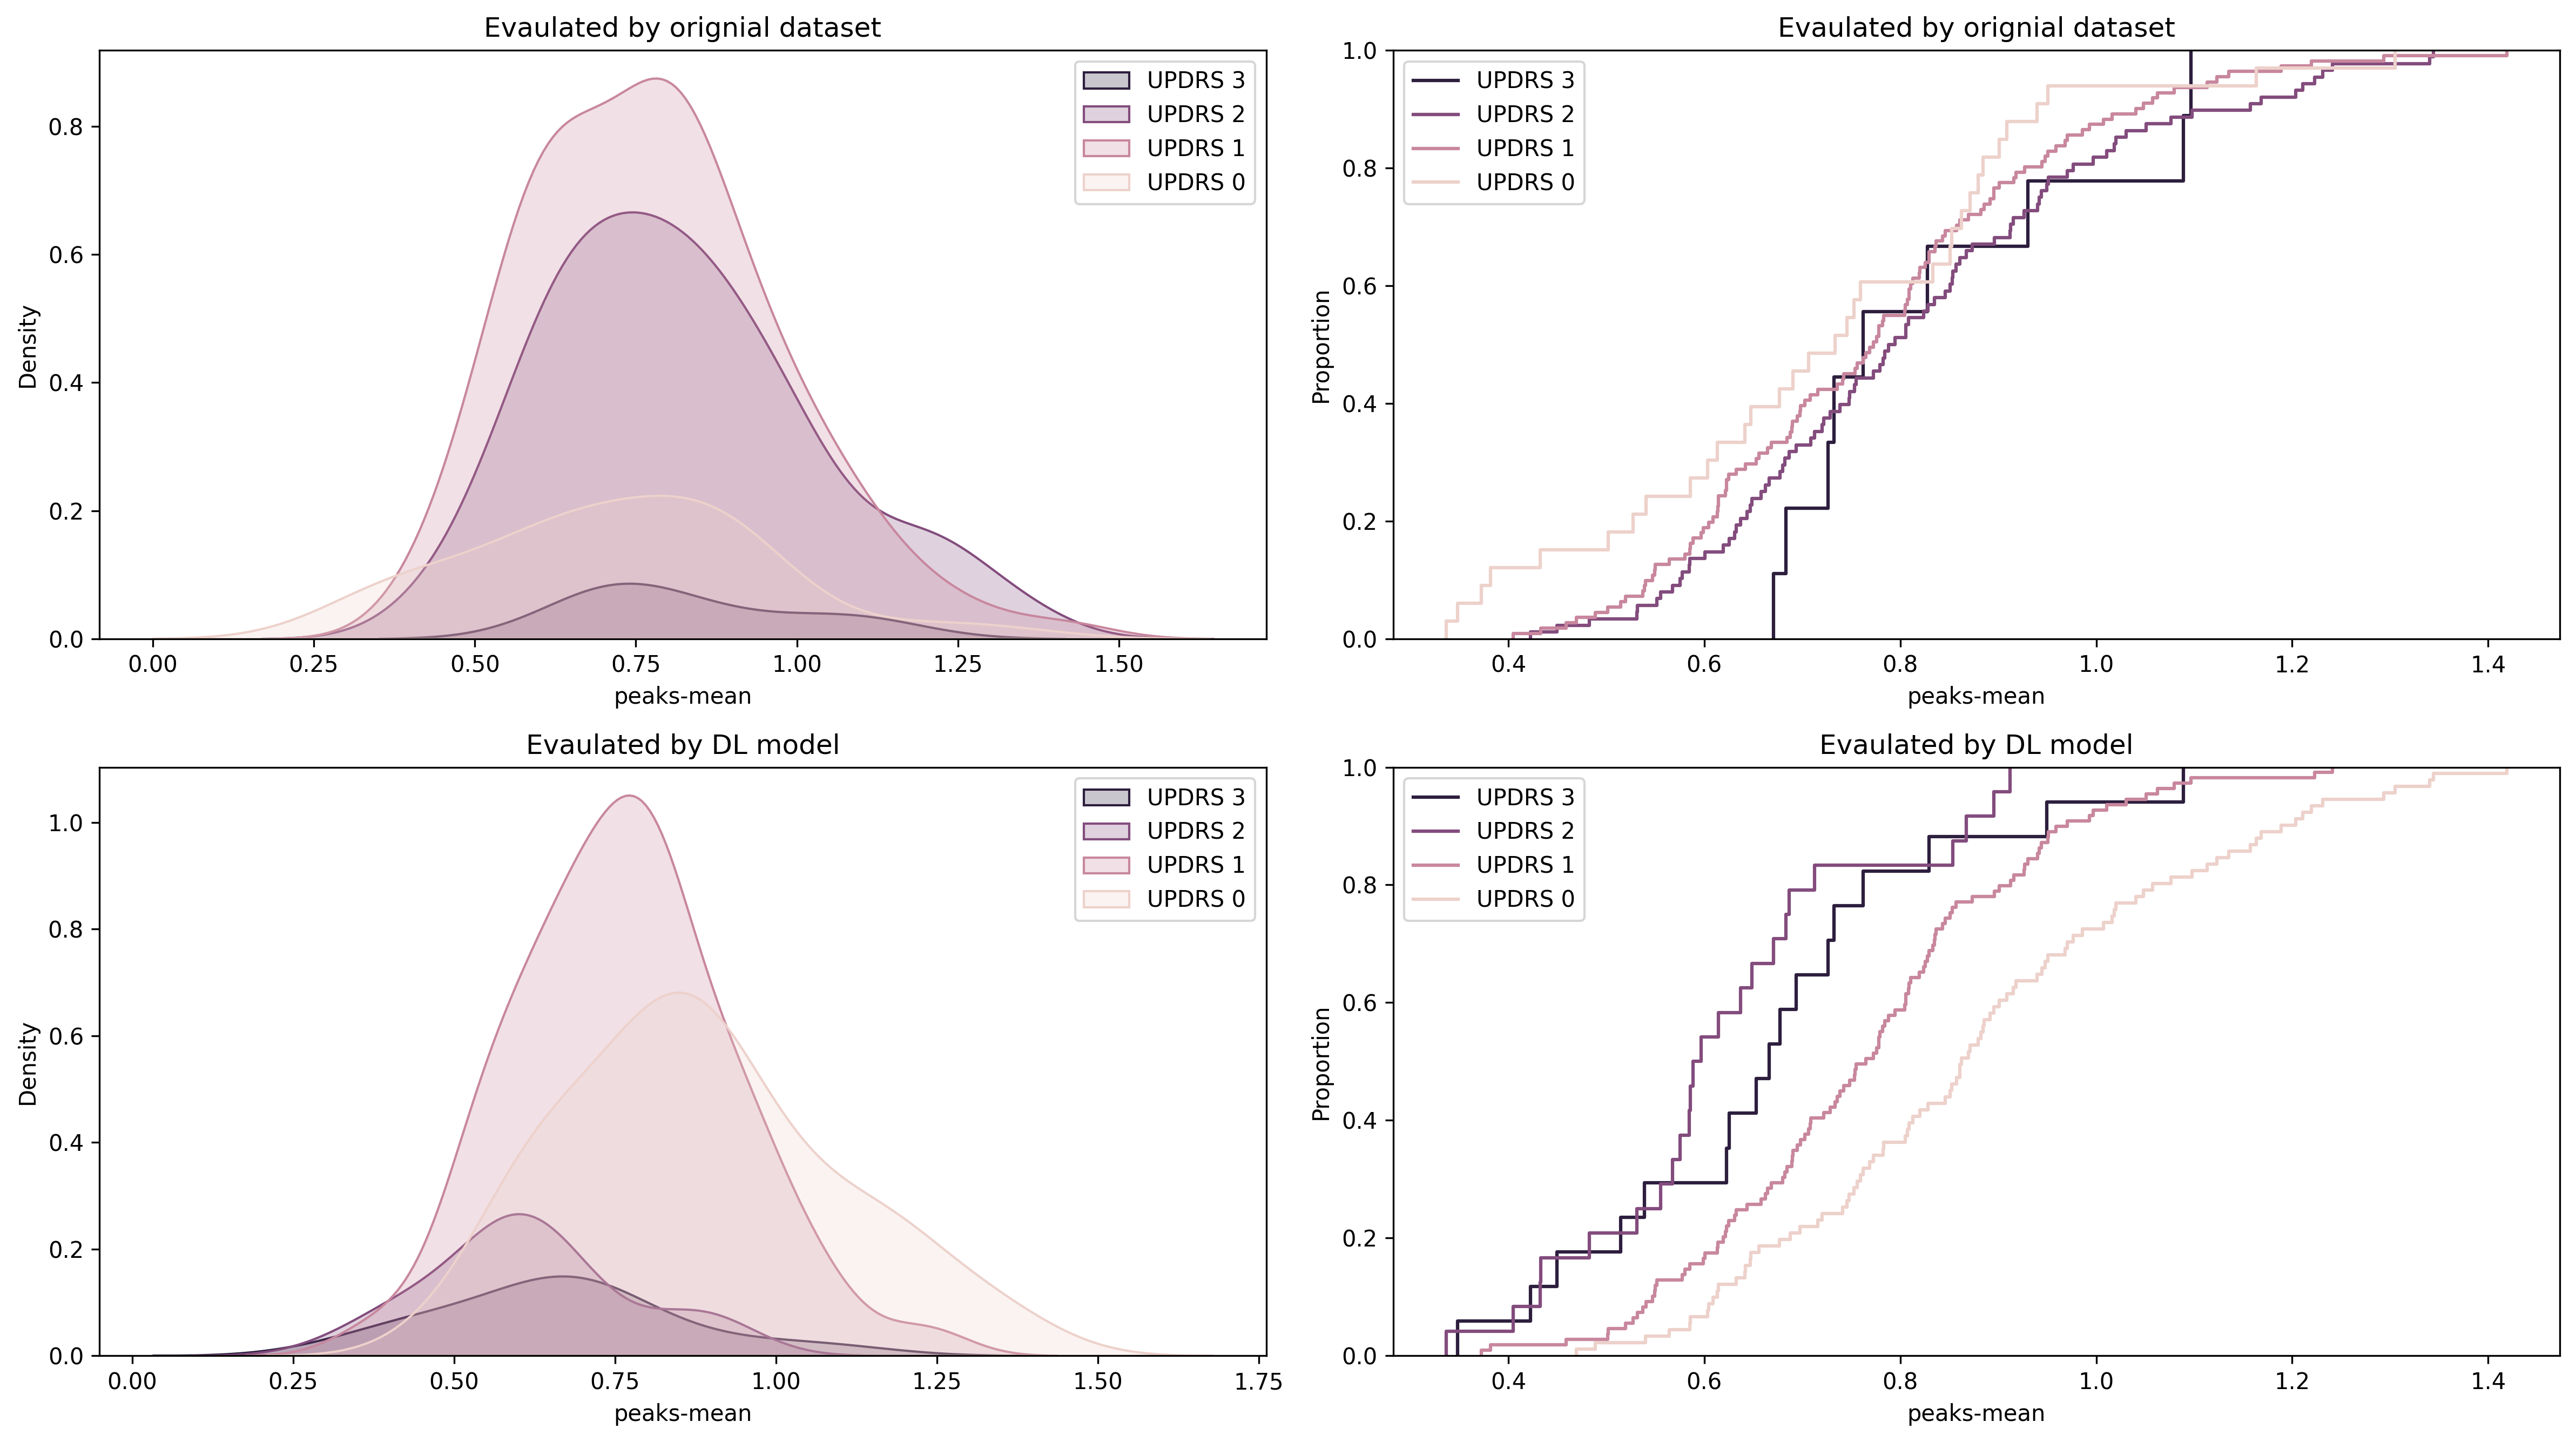

In [9]:
quick_compare(xlabel="peaks-mean")

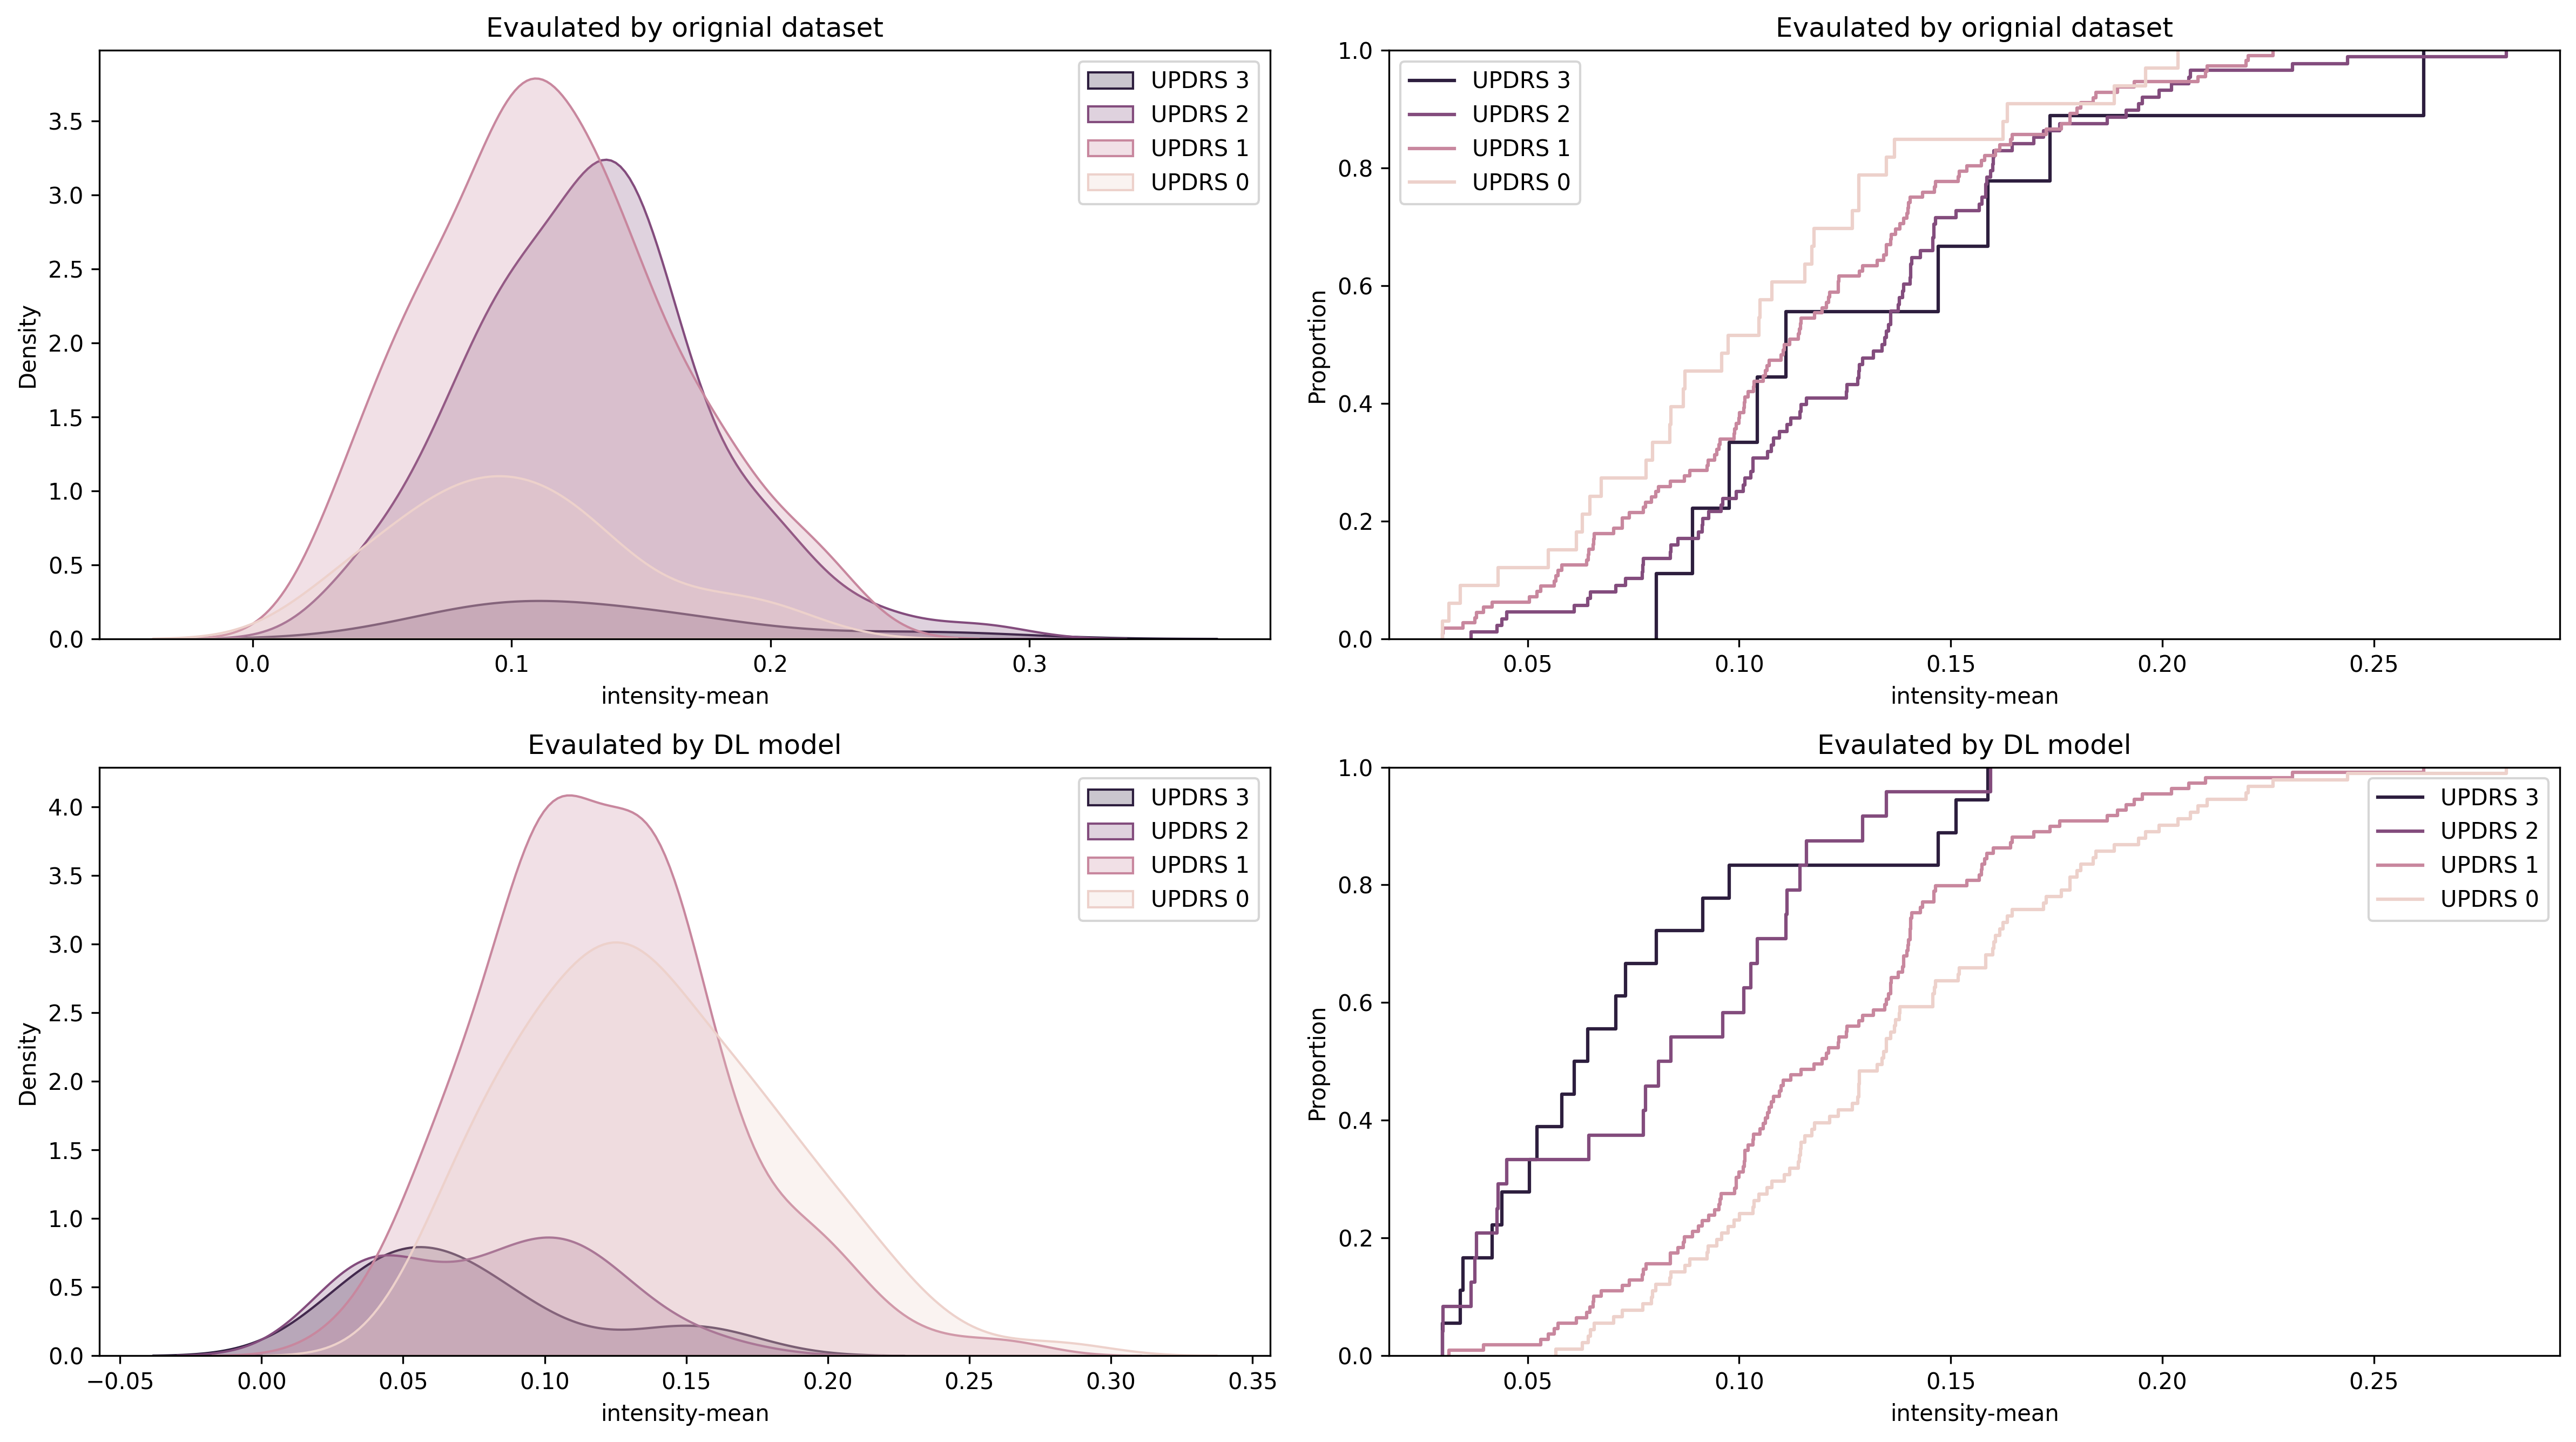

In [10]:
quick_compare(xlabel="intensity-mean")

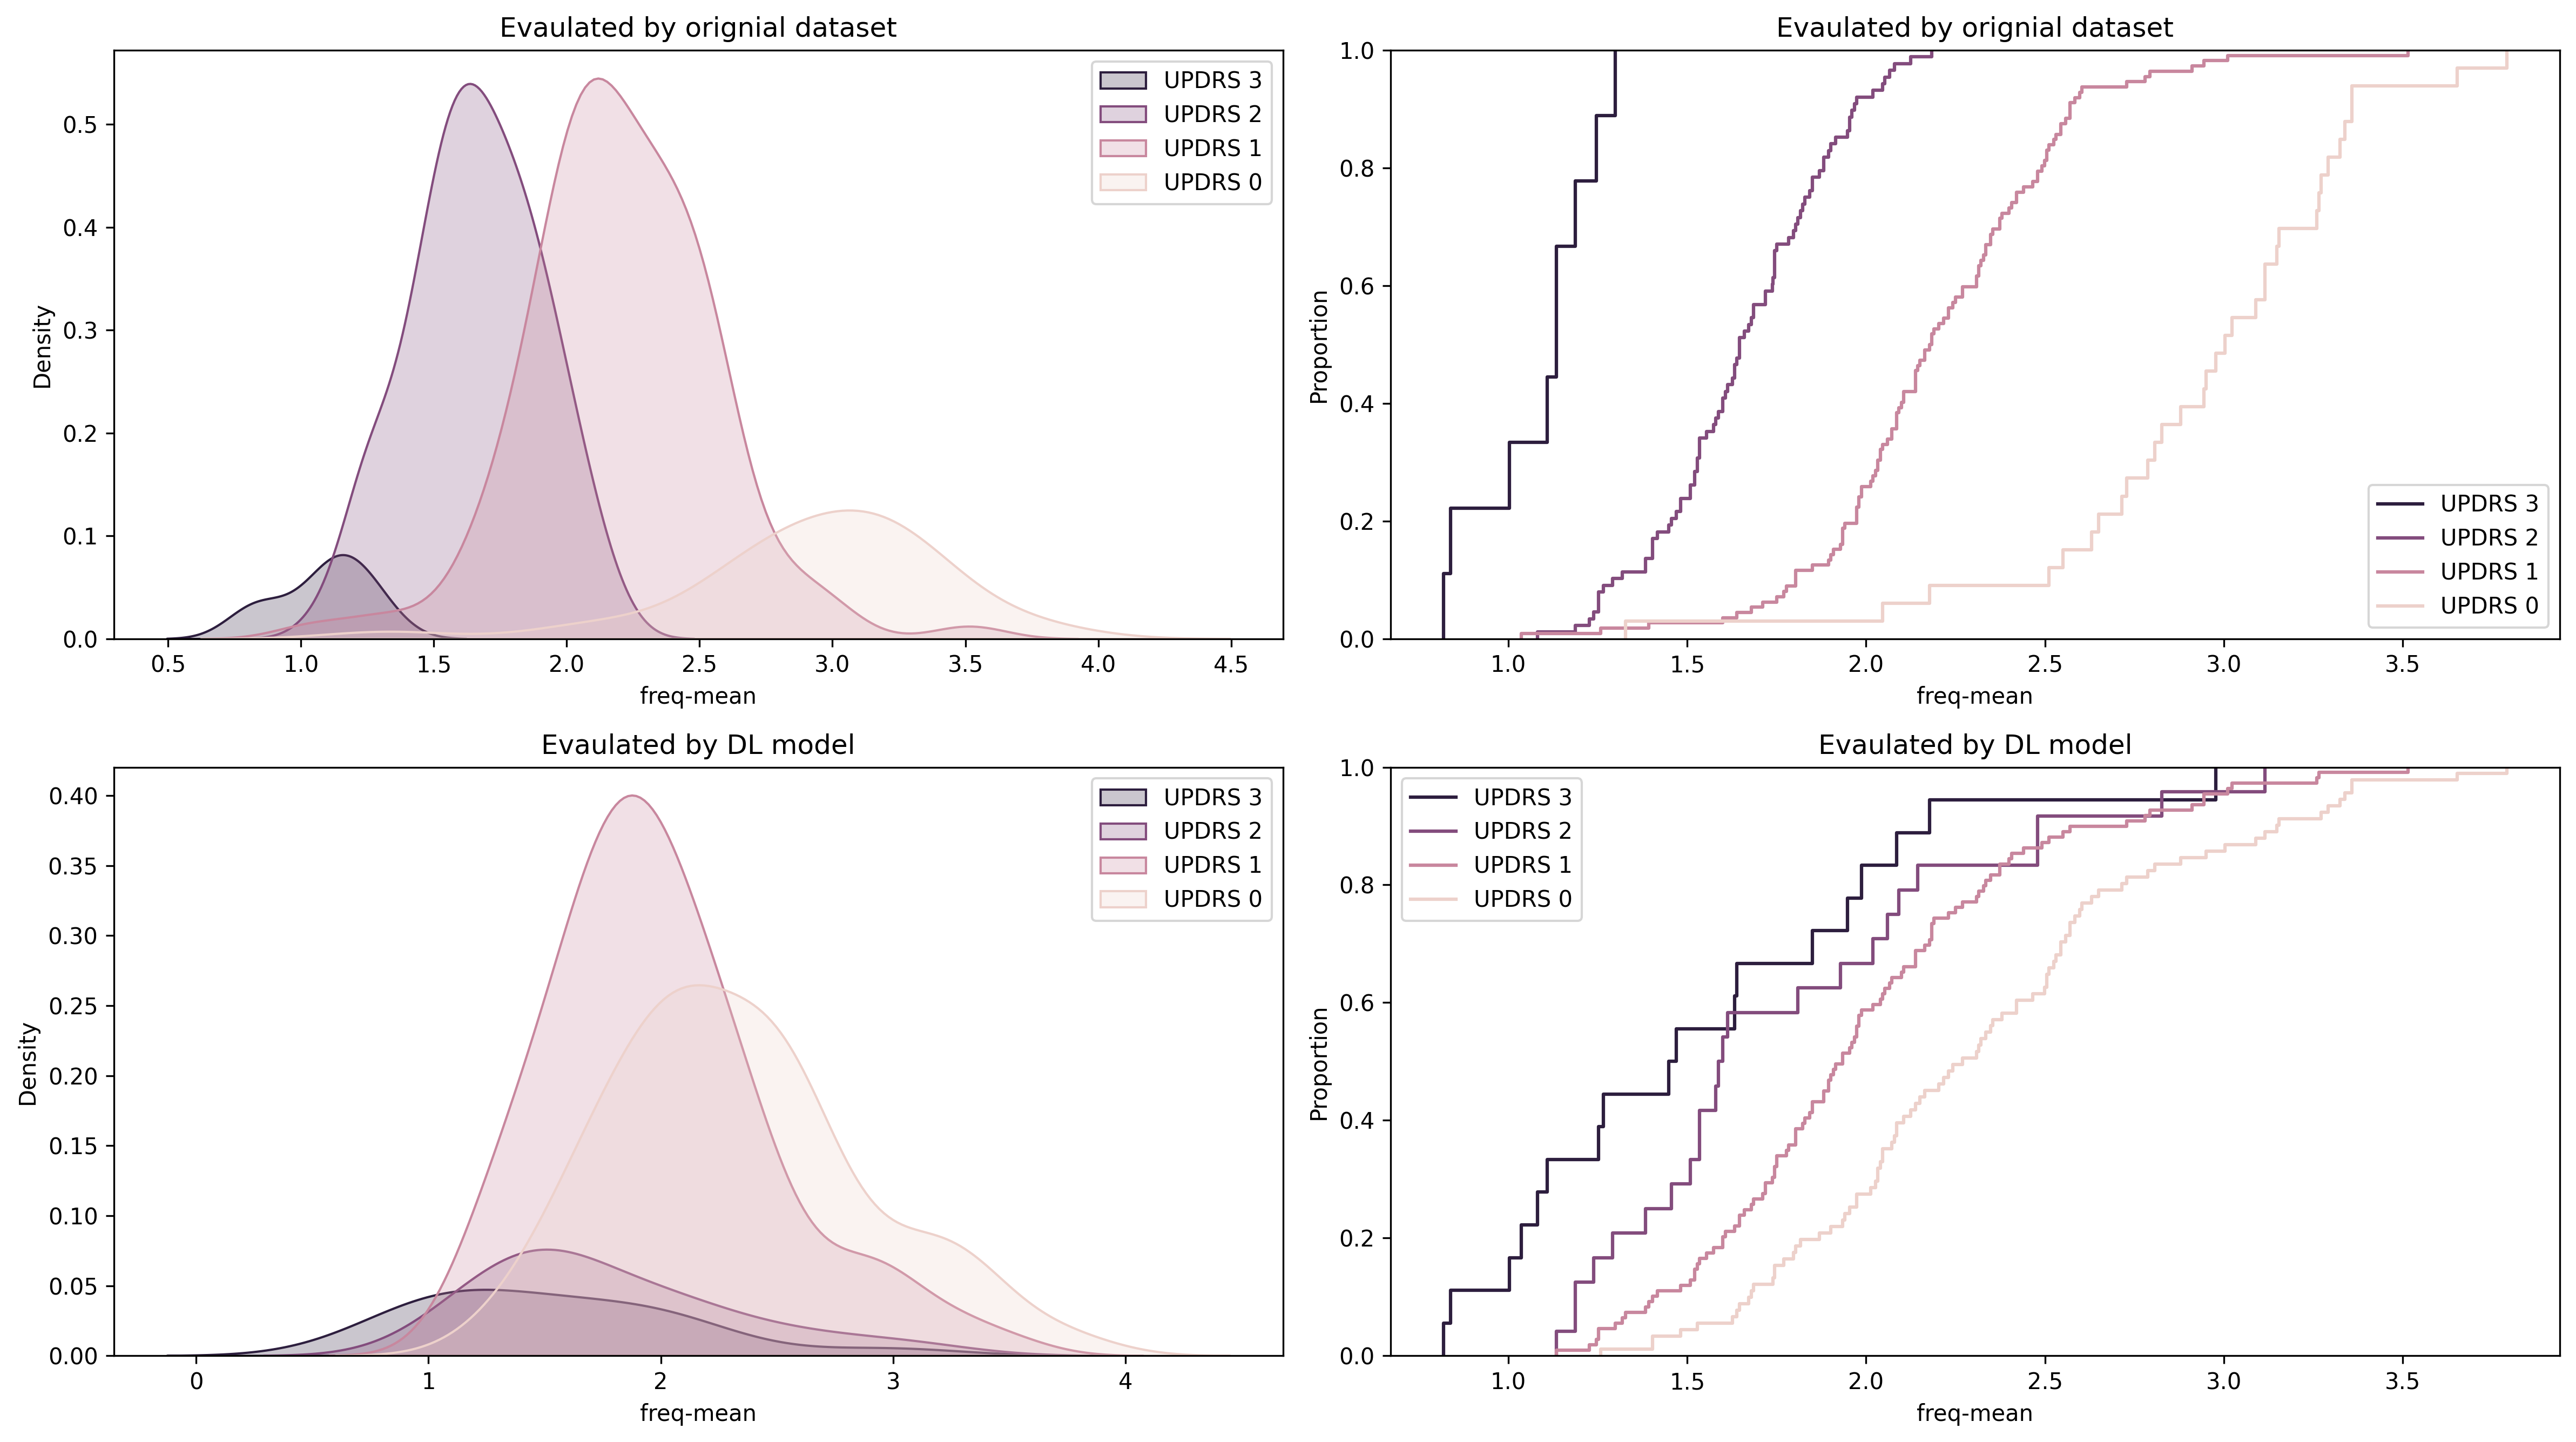

In [11]:
quick_compare(xlabel="freq-mean")

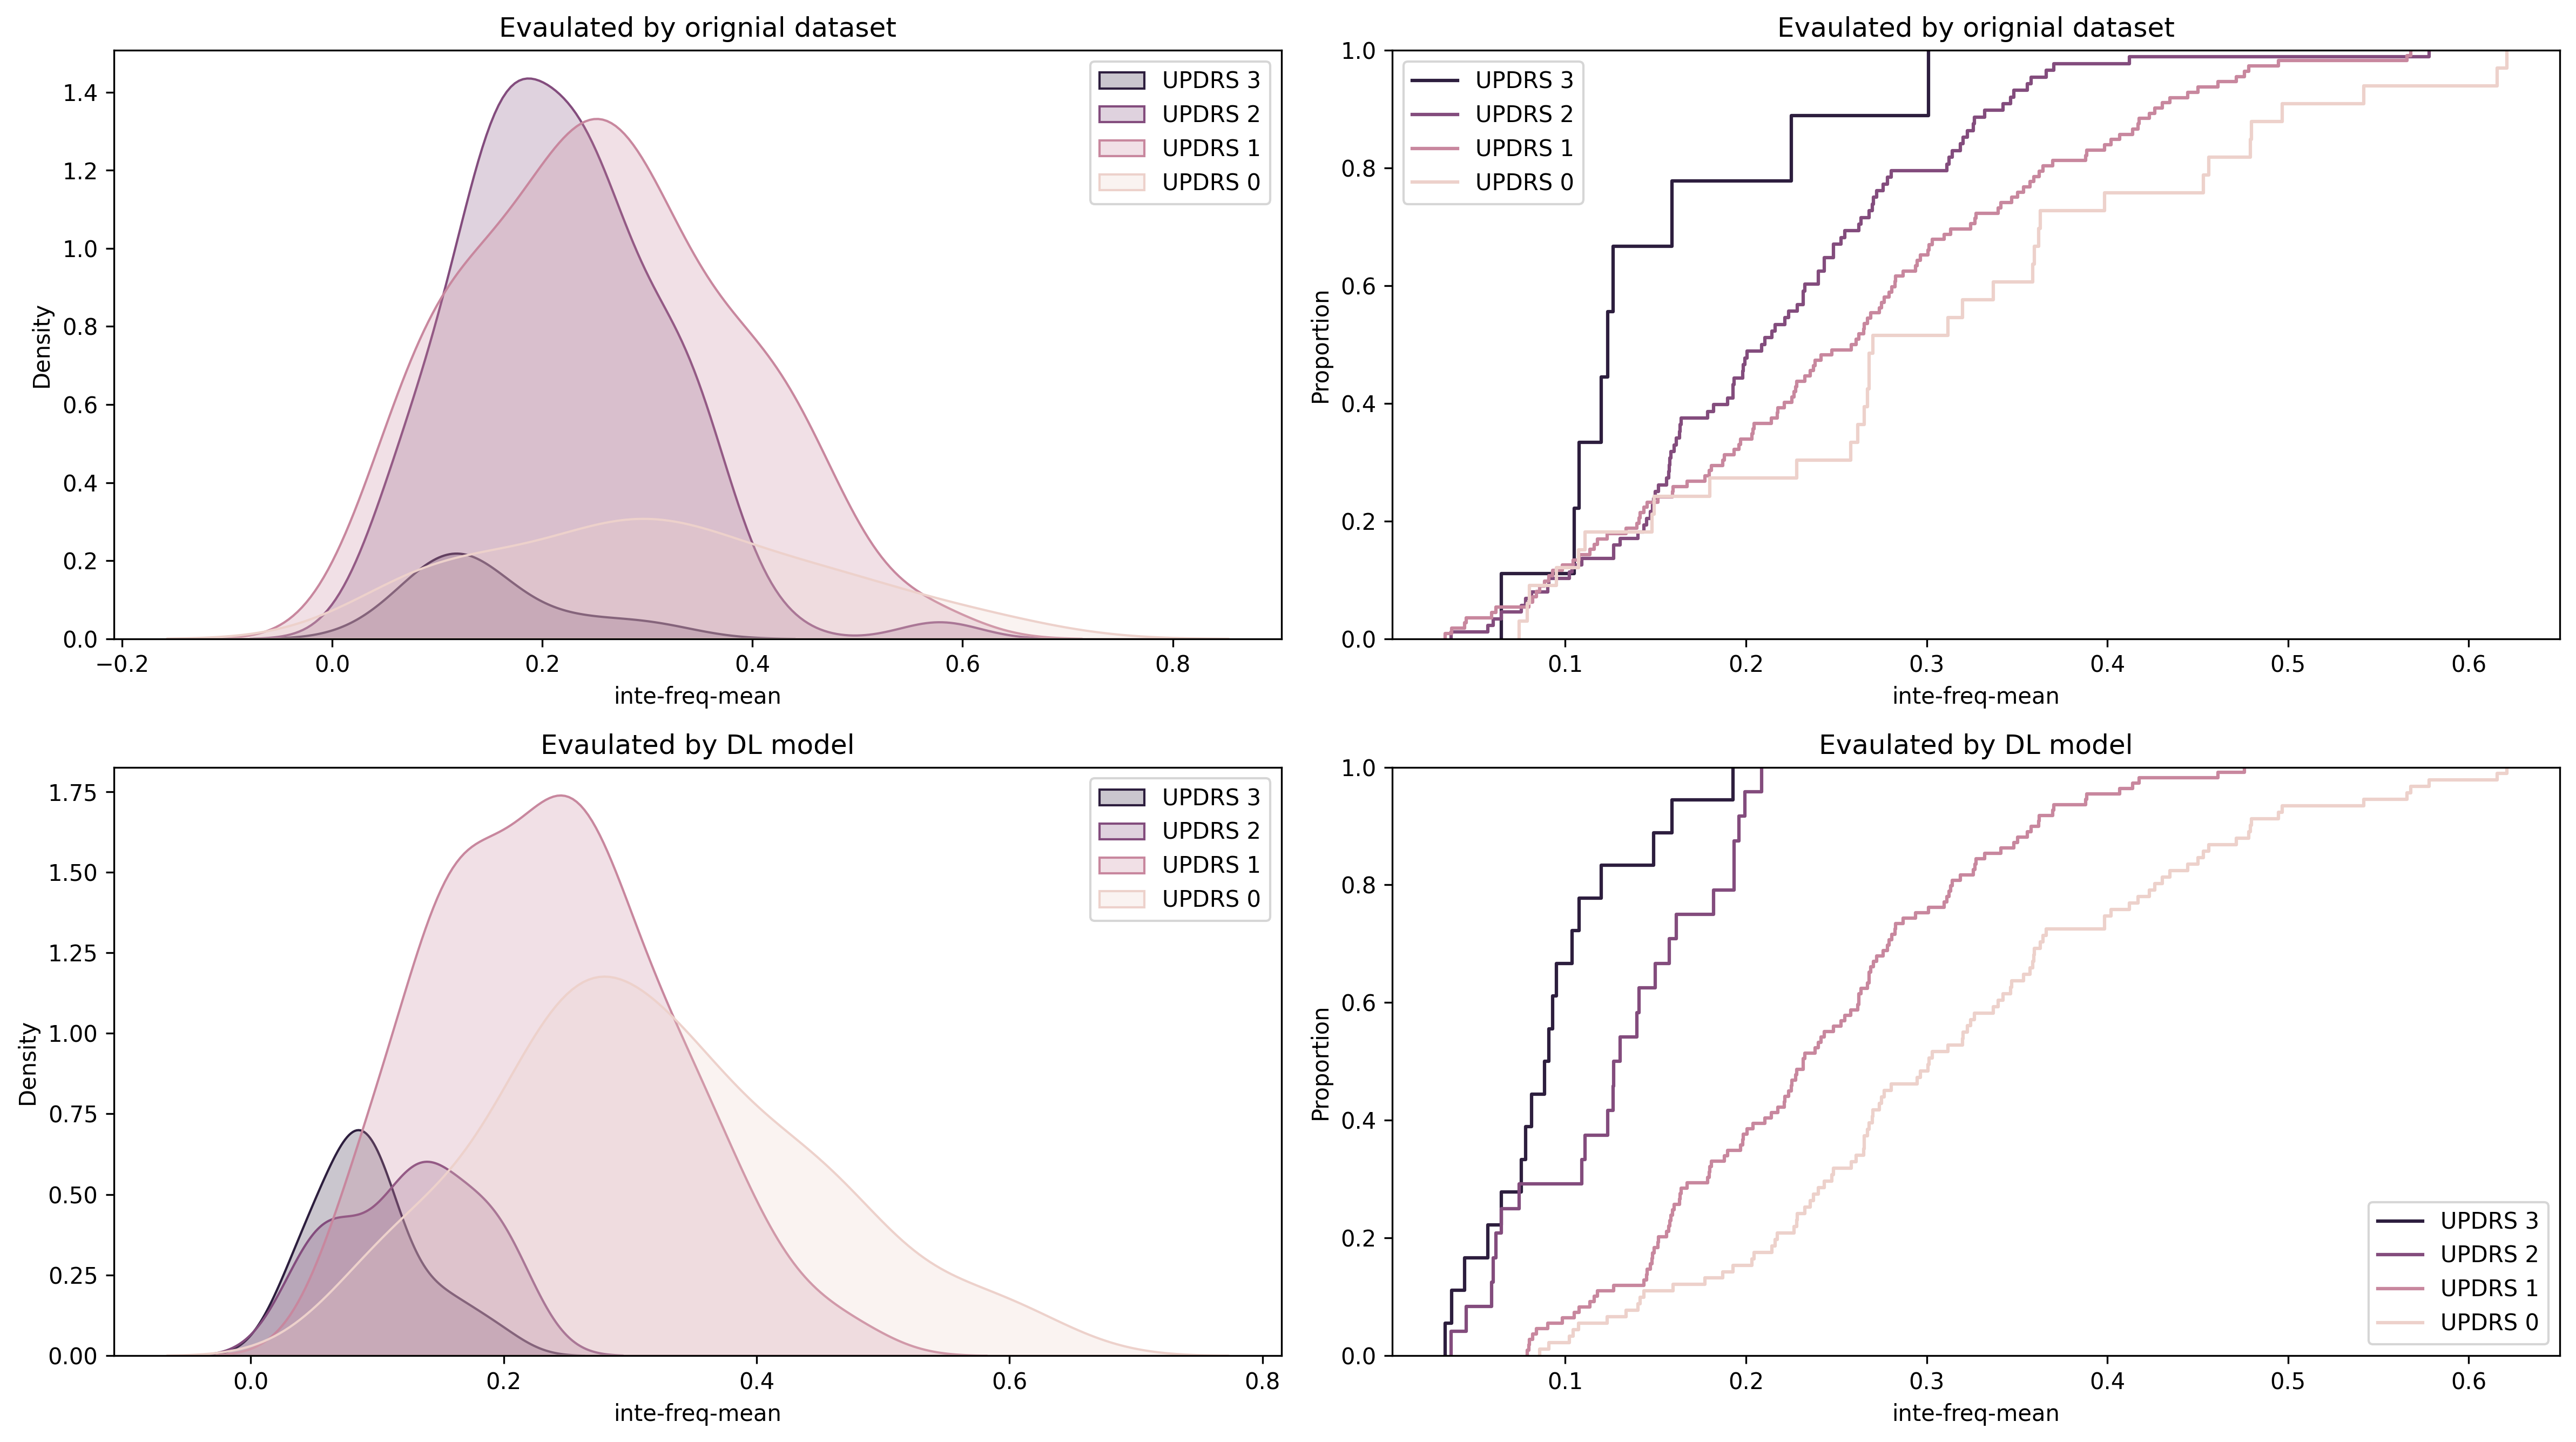

In [12]:
quick_compare(xlabel="inte-freq-mean")